In [1]:
import os

# Replace source_dir with your path to ?/wisdm-dataset/arff_files/phone/accel
#source_dir = "/home/work/Final_Project/data/wisdm-dataset/arff_files/phone/accel"
output_dir = os.path.join(source_dir, "csv_clean")

os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(source_dir):
    if filename.endswith(".arff"):
        with open(os.path.join(source_dir, filename), "r") as infile:
            lines = infile.readlines()
        
        # Find the line where data starts
        try:
            start_index = lines.index("@data\n") + 1
        except ValueError:
            continue  # Skip malformed ARFF

        data_lines = lines[start_index:]
        output_file = os.path.join(output_dir, filename.replace(".arff", ".csv"))

        with open(output_file, "w") as outfile:
            outfile.writelines(data_lines)

print("Finished cleaning ARFF files into CSV format.")


Finished cleaning ARFF files into CSV format.


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("WISDM_EDA").getOrCreate()

df = spark.read.csv(
    "file:///home/work/Final_Project/data/wisdm-dataset/arff_files/phone/accel/csv_clean/*.csv",
    header=False, inferSchema=True
)

# Optionally rename first column as 'activity'
df = df.withColumnRenamed("_c0", "activity")
df.show(5)


+--------+---+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-------+--------+---------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+----------+---------+--------+---------+---------+-------+----+
|activity|_c1| _c2|  _c3|  _c4|  _c5|  _c6|  _c7|  _c8|  _c9| _c10| _c11| _c12| _c13| _c14| _c15| _c16| _c17| _c18|_c19|_c20| _c21| _c22| _c23| _c24| _c25| _c26| _c27| _c28| _c29| _c30|   _c31|    _c32|     _c33|   _c34|   _c35|   _c36|   _c37|   _c38|   _c39| 

In [3]:
# Print inferred schema
df.printSchema()

# Show first few rows
df.show(5, truncate=False)


root
 |-- activity: string (nullable = true)
 |-- _c1: double (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: double (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: double (nullable = true)
 |-- _c7: double (nullable = true)
 |-- _c8: double (nullable = true)
 |-- _c9: double (nullable = true)
 |-- _c10: double (nullable = true)
 |-- _c11: double (nullable = true)
 |-- _c12: double (nullable = true)
 |-- _c13: double (nullable = true)
 |-- _c14: double (nullable = true)
 |-- _c15: double (nullable = true)
 |-- _c16: double (nullable = true)
 |-- _c17: double (nullable = true)
 |-- _c18: double (nullable = true)
 |-- _c19: double (nullable = true)
 |-- _c20: double (nullable = true)
 |-- _c21: double (nullable = true)
 |-- _c22: double (nullable = true)
 |-- _c23: double (nullable = true)
 |-- _c24: double (nullable = true)
 |-- _c25: double (nullable = true)
 |-- _c26: double (nullable = true)
 |-- _c27: double (nullable 

In [4]:
# Show descriptive stats (mean, stddev, min, max) for all numeric columns
df.describe().show()

[Stage 8:>                                                          (0 + 1) / 1]

+-------+--------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------

In [5]:
from pyspark.sql.functions import col

# Count frequency of each activity code (e.g., A, B, C...)
activity_counts = df.groupBy("activity").count().orderBy("count", ascending=False)
activity_counts.show()


+--------+-----+
|activity|count|
+--------+-----+
|       M| 1466|
|       O| 1431|
|       P| 1413|
|       B| 1314|
|       K| 1310|
|       E| 1283|
|       G| 1282|
|       A| 1271|
|       R| 1270|
|       D| 1263|
|       S| 1261|
|       H| 1252|
|       L| 1242|
|       Q| 1241|
|       I| 1236|
|       F| 1180|
|       C| 1180|
|       J| 1179|
+--------+-----+



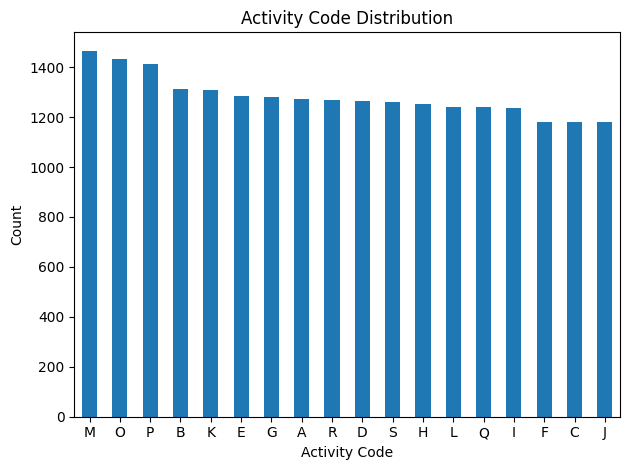

In [6]:
import matplotlib.pyplot as plt

# Convert to Pandas for plotting (only safe for small datasets)
activity_pd = activity_counts.toPandas()

# Plot bar chart
activity_pd.plot(kind="bar", x="activity", y="count", legend=False)
plt.title("Activity Code Distribution")
plt.xlabel("Activity Code")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


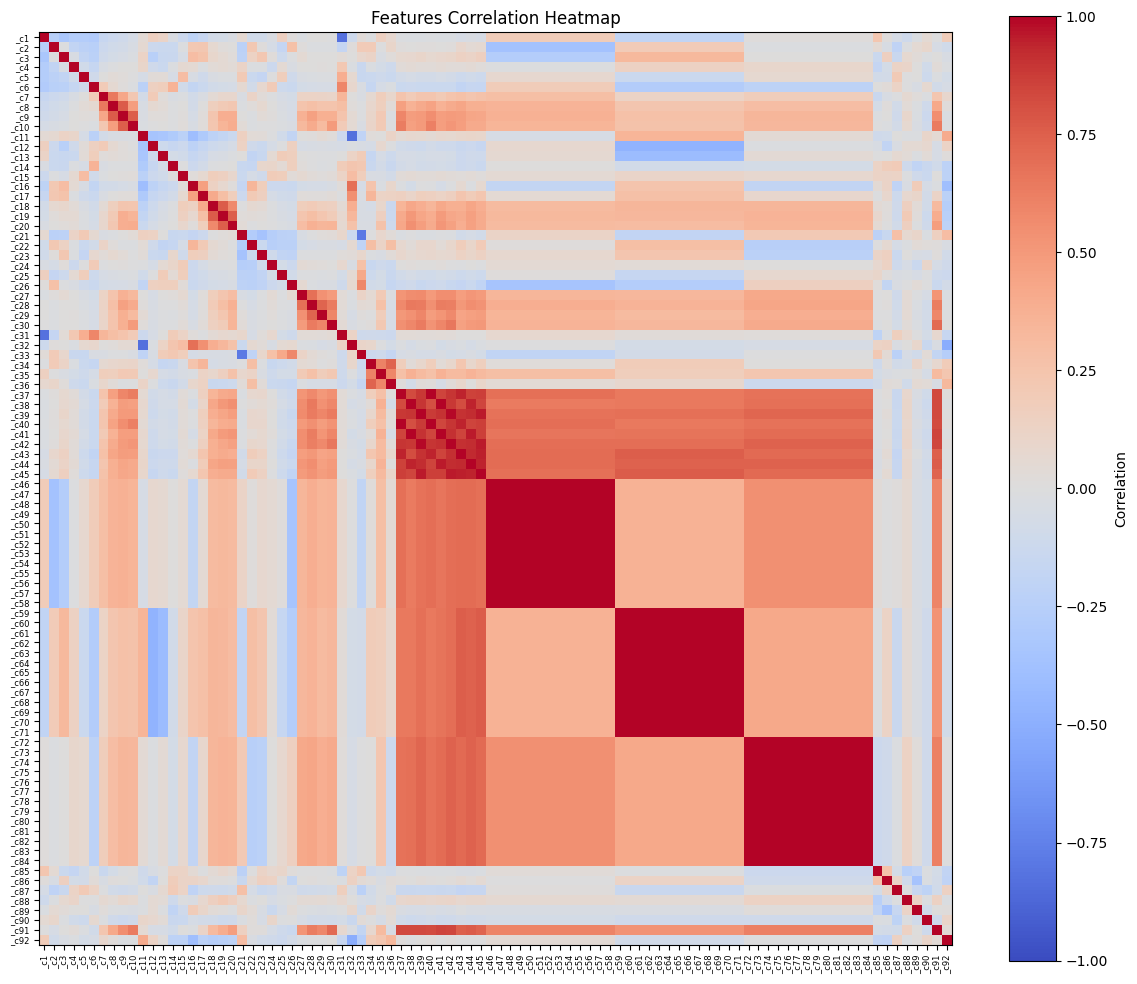

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Select numeric columns
numeric_cols = [f"_c{i}" for i in range(1, 93)]
numeric_df = df.select([col(c).cast("double") for c in numeric_cols])

# Sample and convert to Pandas
numeric_sample = numeric_df.sample(False, 0.05).toPandas()

# Compute correlation matrix
corr_matrix = numeric_sample.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
plt.imshow(corr_matrix, interpolation='nearest', cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')

# Label axes
tick_marks = np.arange(len(corr_matrix.columns))
plt.xticks(tick_marks, corr_matrix.columns, rotation=90, fontsize=6)
plt.yticks(tick_marks, corr_matrix.columns, fontsize=6)

plt.title("Features Correlation Heatmap")
plt.tight_layout()
plt.show()
